In [1]:
import wandb
import csv
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [17]:
def getAlgTag(group:str, config:dict):

    final = {}

    if 'ga' in group.lower():

        if (config['crossover_rate'] >= 0.95) and (config['mutation_rate'] <= 0.05):
            final['Name'] = 'GA-Exploitative'
            final['Tag'] = 'Exploitative'
        elif (0.85 <= config['crossover_rate'] < 0.95) and (0.05 < config['mutation_rate'] <= 0.1):
            final['Name'] = 'Ga'
            final['Tag'] = 'Neutral'
        else:
            final['Name'] = 'GA-Explorative'
            final['Tag'] = 'Explorative'

    elif 'de' in group.lower():

        if (config['crossover_rate'] >= 0.95) and (config['mutation_rate'] <= 0.05):
            final['Name'] = 'DE-Exploitative'
            final['Tag'] = 'Exploitative'
        elif (0.85 <= config['crossover_rate'] < 0.95) and (0.05 < config['mutation_rate'] <= 0.1):
            final['Name'] = 'DE'
            final['Tag'] = 'Neutral'
        else:
            final['Name'] = 'DE-Explorative'
            final['Tag'] = 'Explorative'

    elif 'es' in group.lower() and 'cma' not in group.lower():

        if 'plus' in group.lower():
            final['Name'] = 'ES-plus'
            final['Tag'] = 'Exploitative'
        else:
            final['Name'] = 'ES-comma'
            final['Tag'] = 'Explorative'

    elif 'pso' in group.lower():

        if config['cognitive_v'] == 0.0:
            final['Name'] = 'PSO-social'
            final['Tag'] = 'Exploitative'
        elif config['social_v'] == 0.0:
            final['Name'] = 'PSO-cognitive'
            final['Tag'] = 'Explorative'
        else:
            final['Name'] = 'PSO'
            final['Tag'] = 'Neutral'

    else:
        final['Name'] = 'CMA-ES'
        final['Tag'] = 'Neutral'

    return final

In [13]:
def wandb_api(group:str):

    #WandB API call
    api = wandb.Api()
    runs = api.runs("bio-ai-2022/AutoGL-EA", filters={"group":group})

    #store experiment configuration
    config = runs[0].config

    #store the best test accuracy within the group
    #store the multiple DFs corresponding to different runs
    best_test_acc = 0
    list_df_original = []
    for run in runs:
        list_df_original.append(run.history())
        if run.summary['test_acc:'] > best_test_acc:
            best_test_acc = run.summary['test_acc:']

    #delete unuseful rows and columns
    list_df_final = []
    for df in list_df_original:
        df_final = df.iloc[:15, [0, 9, 7, 11]]

        if 'CMA' in group:
            df_final['mean_fit'] = df_final['mean_fit'].abs()

        df_final = df_final.rename(columns={"mean_fit": "avg_fit"})
        list_df_final.append(df_final)

    #merge the multiple DFs into one, averaging element-wise values
    df_concat = pd.concat(list_df_final)
    df_means = df_concat.groupby(df_concat.index).mean()
    df_means.index = df_means.index + 1

    #create qualitative variable
    alg_tag = getAlgTag(group, config)
    alg_tag['Accuracy'] = best_test_acc

    return df_means, alg_tag

In [19]:
df_means, alg_tag = wandb_api('CORA-GCN_PSO-Social')
display(df_means)
print(alg_tag)

,std_fit,avg_fit,std_div,avg_div
1,0.026530,0.762053,45.729727,68.121349
2,0.103435,0.740773,94.337346,116.857523
3,0.166103,0.727000,132.869240,170.891777
4,0.153090,0.728560,166.490002,198.530063
5,0.147849,0.722840,222.342198,247.760070
6,0.143366,0.736547,300.290668,301.470955
7,0.206097,0.684480,421.543250,373.739493
8,0.205112,0.677507,303.043096,339.533962
9,0.200291,0.692693,344.199148,355.842917
10,0.181478,0.708853,309.027872,328.463921


{'Name': 'PSO-social', 'Tag': 'Exploitative', 'Accuracy': 0.814}


In [92]:
run_names = ['Ste_test_CORA-GCN_GA-Exploitative', 'CORA-GCN_GA-Neutral', 'CORA-GCN_GA-Explorative', 'CORA-GCN_DE-Exploitative', 'CORA-GCN_DE-Neutral',
'CORA-GCN_DE-Explorative', 'CORA-GCN_ES-comma', 'CORA-GCN_ES-plus', 'CORA-GCN_CMA-ES', 'CORA-GCN_PSO-Social', 'CORA-GCN_PSO', 'CORA-GCN_PSO-Cognitive']

In [ ]:
for group in ['CORA-GCN_CMA-ES', 'CORA-GCN_PSO-Social']:
    api = wandb.Api()
    runs = api.runs("bio-ai-2022/AutoGL-EA", filters={"group":group})
    print("Configuration: ", runs[0].config)
    for i, run in enumerate(runs):
        display(run.history())

In [20]:
numbers = [1,2,3]
letters = ['a', 'b', 'c']

for n,l in zip(numbers, letters):
    print(n, l)

1 a
2 b
3 c


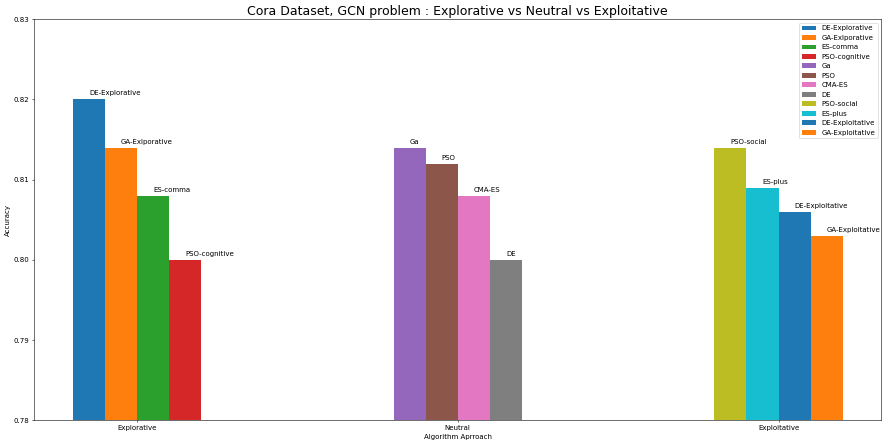

In [85]:
import wandb
import csv

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


"""
This file should be executed after the 5 runs for each of the 12 EA considered. Then repeat this file execution for each Dataset that
has been taken in consideration, and for each GNN model.

INPUT
    - a list of Group Names, which were given as input to WandB, each one representing an experiment, performed internally 5 times.


OUTPUT
    - 12 single plots, each one averaged over 5 runs, representing the Accuracy vs Diversity curves of the EA performed;
    - 1 global plot, representing the overall comparison of the 12 EA in terms of Test Accuracy, where each algorithm is 
      categorized as: Exploitative-Explorative-Neutral, depending on its specific EA hyperparameters. 
"""


def getAlgTag(group:str, config:dict):

    final = {}

    if 'ga' in group.lower():

        if (config['crossover_rate'] >= 0.95) and (config['mutation_rate'] <= 0.05):
            final['Name'] = 'GA-Exploitative'
            final['Tag'] = 'Exploitative'
        elif (0.85 <= config['crossover_rate'] < 0.95) and (0.05 < config['mutation_rate'] <= 0.1):
            final['Name'] = 'Ga'
            final['Tag'] = 'Neutral'
        else:
            final['Name'] = 'GA-Exlporative'
            final['Tag'] = 'Explorative'

    elif 'de' in group.lower():

        if (config['crossover_rate'] >= 0.95) and (config['mutation_rate'] <= 0.05):
            final['Name'] = 'DE-Exploitative'
            final['Tag'] = 'Exploitative'
        elif (0.85 <= config['crossover_rate'] < 0.95) and (0.05 < config['mutation_rate'] <= 0.1):
            final['Name'] = 'DE'
            final['Tag'] = 'Neutral'
        else:
            final['Name'] = 'DE-Explorative'
            final['Tag'] = 'Explorative'

    elif 'es' in group.lower() and 'cma' not in group.lower():

        if 'plus' in group.lower():
            final['Name'] = 'ES-plus'
            final['Tag'] = 'Exploitative'
        else:
            final['Name'] = 'ES-comma'
            final['Tag'] = 'Explorative'

    elif 'pso' in group.lower():

        if config['cognitive_v'] == 0.0:
            final['Name'] = 'PSO-social'
            final['Tag'] = 'Exploitative'
        elif config['social_v'] == 0.0:
            final['Name'] = 'PSO-cognitive'
            final['Tag'] = 'Explorative'
        else:
            final['Name'] = 'PSO'
            final['Tag'] = 'Neutral'

    else:

        final['Name'] = 'CMA-ES'
        final['Tag'] = 'Neutral'

    return final


def wandb_api(group:str):

    #WandB API call
    api = wandb.Api()
    runs = api.runs("bio-ai-2022/AutoGL-EA", filters={"group":group})

    #store experiment configuration
    config = runs[0].config

    #store the best test accuracy within the group
    #store the multiple DFs corresponding to different runs
    best_test_acc = 0
    list_df_original = []
    for run in runs:
        list_df_original.append(run.history())
        if run.summary['test_acc:'] > best_test_acc:
            best_test_acc = run.summary['test_acc:']

    #delete unuseful rows and columns
    list_df_final = []
    for df in list_df_original:
        df_final = df.iloc[:15, [0, 9, 7, 11]]

        if 'CMA' in group:
            df_final['mean_fit'] = df_final['mean_fit'].abs()

        df_final = df_final.rename(columns={"mean_fit": "avg_fit"})
        list_df_final.append(df_final)

    #merge the multiple DFs into one, averaging element-wise values
    df_concat = pd.concat(list_df_final)
    df_means = df_concat.groupby(df_concat.index).mean()
    df_means.index = df_means.index + 1

    #create qualitative variable
    alg_tag = getAlgTag(group, config)
    alg_tag['Accuracy'] = best_test_acc

    return df_means, alg_tag


def plot_acc_div(alg_list:list, run_names:list, title:str):

    n_cols = 3
    n_rows = 4

    fig, axes = plt.subplots(n_cols, n_rows, figsize=(32, 18), dpi=50)
    plt.subplots_adjust(wspace=0.25, hspace=0.4)

    #alg_list[count].plot(ax=axes[r,c])

    count=0
    for r in range(n_rows):
        for c in range(n_cols):

            df = alg_list[count]
            group = run_names[count]

            x = df.index
            y1 = df.avg_fit
            y2 = df.avg_div

            axes[r,c].plot(x, y1, color="tab:red")
            axes[r,c].fill_between(x, y1 + (df.std_fit*0.2), y1 - (df.std_fit*0.2), alpha = 0.2, color="tab:red")

            ax2 = axes[r,c].twinx()
            ax2.plot(x, y2, color="tab:blue")
            ax2.fill_between(x, y2 + (df.std_div*0.1), y2 - (df.std_div*0.1), alpha = 0.2, color="tab:blue")

            # ax1 (left y axis)
            axes[r,c].set_xlabel("Generations", fontsize=20)
            axes[r,c].set_ylabel("Accuracy", color="tab:red", fontsize=20)
            axes[r,c].tick_params(axis="y", rotation=0, labelcolor="tab:red")

            # ax2 (right Y axis)
            ax2.set_ylabel("Diversity", color="tab:blue", fontsize=20)
            ax2.tick_params(axis="y", labelcolor="tab:blue")
            ax2.set_title(
                "{group} - Accuracy vs Diversity".format(group=group), fontsize=20
            )
            ax2.set_xticks(np.arange(1, len(x) + 1, 1))
            ax2.set_xticklabels(x[::1], rotation=90, fontdict={"fontsize": 10})

            count+=1

    plt.savefig('{group}.png'.format(group=title))
    plt.show()

    return


def comparison_plot(alg_tags:list, title:str):

    df = pd.DataFrame(alg_tags)
    df.sort_values(by='Accuracy', ascending=False, inplace=True)

    labels = df.Tag.unique()

    x = np.arange(len(labels))
    width = 0.1

    fig, ax = plt.subplots(figsize=(18,9), dpi=50)

    for i, tag in enumerate(labels):
        df_small = df.loc[df.Tag == tag, :]
        count = 0
        for alg in df_small.values:
            if count == 0:
                rect1 = ax.bar(x[i] - 1.5*width, alg[2], width, label=alg[0])
                plt.text(x[i] - 1.5*width, alg[2]+0.0005, s = alg[0], horizontalalignment='left', fontsize='medium')
            elif count == 1:
                rect2 = ax.bar(x[i] - width/2, alg[2], width, label=alg[0])
                plt.text(x[i] - width/2, alg[2]+0.0005, s = alg[0], horizontalalignment='left', fontsize='medium')
            elif count == 2:
                rect3 = ax.bar(x[i] + width/2, alg[2], width, label=alg[0])
                plt.text(x[i] + width/2, alg[2]+0.0005, s = alg[0], horizontalalignment='left', fontsize='medium')
            else:
                rect4 = ax.bar(x[i] + 1.5*width, alg[2], width, label=alg[0])
                plt.text(x[i] + 1.5*width, alg[2]+0.0005, s = alg[0], horizontalalignment='left', fontsize='medium')
            count += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Algorithm Aprroach')
    ax.set_ylabel('Accuracy')
    ax.set_title("Cora Dataset, GCN problem : Explorative vs Neutral vs Exploitative", fontsize=18)
    ax.set_xticks(x, labels)
    ax.set_ylim(0.78, 0.83)
    ax.legend()

    fig.tight_layout()

    plt.savefig('comparison_{group}.png'.format(group=title))
    plt.show()

    """# Data preparation
    # Create as many colors as there are unique df['Name']
    categories = df['Name']
    colors = [plt.cm.tab10(i/float(len(categories)-1)) for i in range(len(categories))]

    # Draw Plot for Each Category
    plt.figure(figsize=(24, 10), dpi=72, facecolor='w', edgecolor='k')
    for i, category in enumerate(categories):
        plt.scatter('Tag', 'Accuracy', 
                    data=df.loc[df.Name==category, :], 
                    s=50, c=np.array(colors[i]).reshape((1,4)), label=str(category))
        plt.text(x = df.Tag[i], y = df.Accuracy[i]+0.0005, s = category, horizontalalignment='center', fontsize='medium')
        


    # Decorations
    plt.gca().set(xlabel='Algorithm Aprroach', ylabel='Accuracy')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=6, fancybox=True, shadow=True)
    plt.xticks(fontsize=12); plt.yticks(fontsize=12)
    plt.title("Cora Dataset, GCN problem : Explorative vs Neutral vs Exploitative", fontsize=18, x=0.5, y=1.1)
    plt.savefig('comparison_{group}.png'.format(group=title))
    plt.show()"""

    return 

def save_best_decoded_individual(group_name:str, test_acc:int, trainer:dict, model:dict):

    final = {"Test_Acc": test_acc}
    final.update(trainer)
    final.update(model)

    final = {'early_stopping' if k == 'early_stopping_round' else k:v for k,v in final.items()}
    final = {'hidden_nodes' if k == 'hidden' else k:v for k,v in final.items()}
    final['hidden_nodes'] = final['hidden_nodes'][0]

    with open('{name}.csv'.format(name=group_name), "a", newline='') as f:
        writer = csv.DictWriter(f, fieldnames=final.keys())
        writer.writeheader()
        writer.writerow(final)

    return


def main(run_names:list()):

    """
    Example of the input: 
        run_names = ['GA Test - Neutral Setting', 'ES-plus Test - Explorative Setting', 'ES-comma Test - Explorative Setting']
    """

    alg_list = []
    alg_tags = []
    
    for exp in run_names:
        df, alg_tag = wandb_api(exp)
        #plot_acc_div(df, exp)
        alg_list.append(df)
        alg_tags.append(alg_tag)

    #plot_acc_div(alg_list, run_names, 'CORA-GCN')
    comparison_plot(alg_tags, 'CORA-GCN')
    
    

if __name__ == '__main__':
    list_name = ['Ste_test_CORA-GCN_GA-Exploitative', 'CORA-GCN_GA-Neutral', 'CORA-GCN_GA-Explorative', 'CORA-GCN_DE-Exploitative', 
                 'CORA-GCN_DE-Neutral', 'CORA-GCN_DE-Explorative', 'CORA-GCN_ES-comma', 'CORA-GCN_ES-plus', 'CORA-GCN_CMA-ES', 'CORA-GCN_PSO-Social', 'CORA-GCN_PSO', 'CORA-GCN_PSO-Cognitive']

    main(list_name)

0.82
0.814
0.808
0.8
0.814
0.812
0.808
0.8
0.814
0.809
0.806
0.803


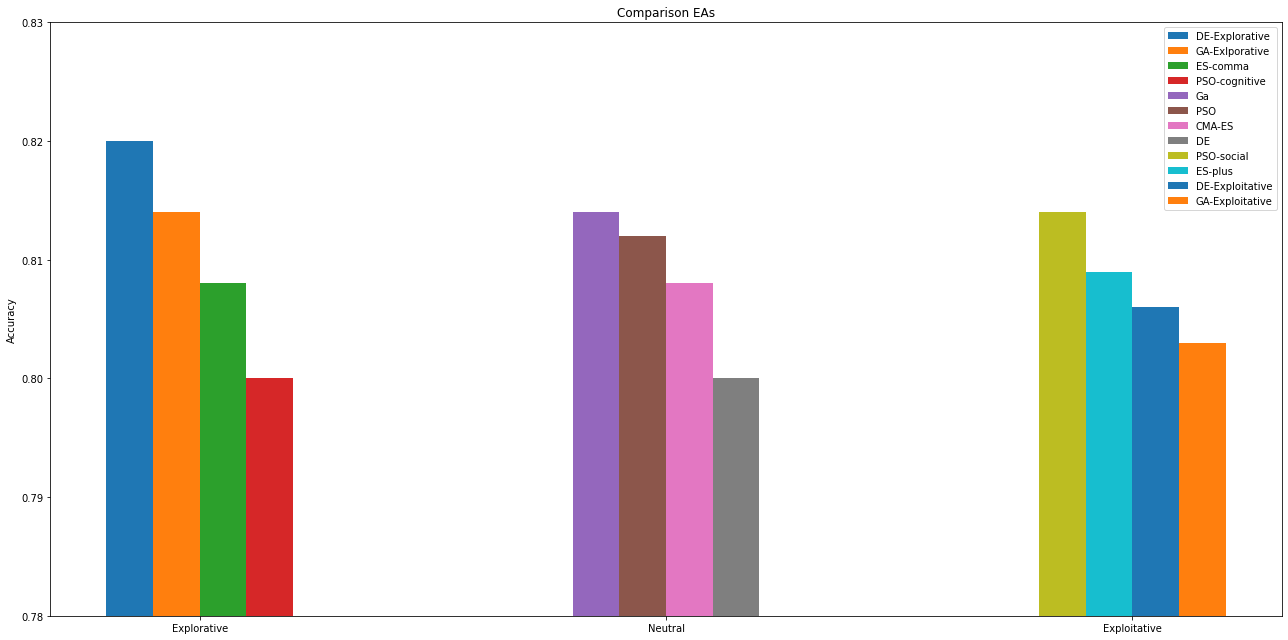

In [82]:
labels = df_final.Tag.unique()

x = np.arange(len(labels))
width = 0.1

fig, ax = plt.subplots(figsize=(18,9))

for i, tag in enumerate(labels):
    df_small = df_final.loc[df_final.Tag == tag, :]
    count = 0
    for alg in df_small.values:
        if count == 0:
            rect1 = ax.bar(x[i] - 1.5*width, alg[2], width, label=alg[0])
        elif count == 1:
            rect2 = ax.bar(x[i] - width/2, alg[2], width, label=alg[0])
        elif count == 2:
            rect3 = ax.bar(x[i] + width/2, alg[2], width, label=alg[0])
        else:
            rect4 = ax.bar(x[i] + 1.5*width, alg[2], width, label=alg[0])
        count += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Comparison EAs')
ax.set_xticks(x, labels)
ax.set_ylim(0.78, 0.83)
ax.legend()

fig.tight_layout()

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

### Plot 3

In [2]:
df_original = pd.read_csv('Bio-AI_runs.csv')

df_final = df_original.loc[df_original.groupby("group_name")["Test_Acc"].idxmax()]
df_final.drop('num_layers', axis=1, inplace=True)

display(df_final)





,group_name,Test_Acc,max_epoch,early_stopping,lr,weight_decay,hidden_nodes,dropout,act
42,CORA-GCN_CMA-ES,0.808,181,26,0.046660,0.000170,16,0.800000,tanh
17,CORA-GCN_DE-Exploitative,0.806,237,15,0.035991,0.000455,14,0.200000,relu
29,CORA-GCN_DE-Explorative,0.820,221,23,0.024422,0.000163,16,0.800000,relu
23,CORA-GCN_DE-Neutral,0.800,143,17,0.017965,0.000395,11,0.265132,relu
31,CORA-GCN_ES-comma,0.808,126,16,0.050000,0.000416,16,0.702171,elu
38,CORA-GCN_ES-plus,0.809,273,20,0.021078,0.000706,16,0.700890,leaky_relu
4,CORA-GCN_GA-Exploitative,0.803,272,26,0.040128,0.000576,15,0.758822,leaky_relu
13,CORA-GCN_GA-Explorative,0.814,212,25,0.013366,0.000827,15,0.754682,elu
8,CORA-GCN_GA-Neutral,0.814,288,23,0.015894,0.000107,13,0.792738,leaky_relu
51,CORA-GCN_PSO,0.812,52,20,0.033809,0.001000,16,0.683696,leaky_relu


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


['setosa' 'versicolor' 'virginica']


c:\Users\flori\anaconda3\envs\bio_venv\lib\site-packages\paxplot\core.py:839: Warning: The function you have called (set_tight_layout) is not officially supported by Paxplot, but it may still work. Report issues to https://github.com/kravitsjacob/paxplot/issues
  warnings.warn(
c:\Users\flori\anaconda3\envs\bio_venv\lib\site-packages\paxplot\core.py:839: Warning: The function you have called (set_canvas) is not officially supported by Paxplot, but it may still work. Report issues to https://github.com/kravitsjacob/paxplot/issues
  warnings.warn(


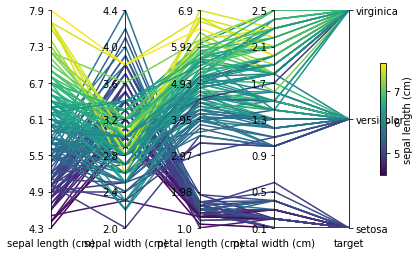

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
import paxplot
from matplotlib.pyplot import figure

# Import data
iris = load_iris(as_frame=True)
df = pd.DataFrame(
    data=np.c_[iris['data'], iris['target']],
    columns=iris['feature_names'] + ['target']
)

display(df)
cols = df.columns
print(iris.target_names)

# Create figure
paxfig = paxplot.pax_parallel(n_axes=len(cols))
paxfig.plot(df.to_numpy())

# Add labels
paxfig.set_labels(cols)

# Set ticks
paxfig.set_ticks(
    ax_idx=-1,
    ticks=[0, 1, 2],
    labels=iris.target_names
)

# Add colorbar
color_col = 0
paxfig.add_colorbar(
    ax_idx=color_col,
    cmap='viridis',
    colorbar_kwargs={'label': cols[color_col]}
)


plt.show()

In [104]:
df_final.to_numpy()

array([['CORA-GCN_CMA-ES', 0.808, 181, 26, 0.0466599931134837,
        0.0001699397551402, 16, 0.8, 'tanh'],
       ['CORA-GCN_DE-Exploitative', 0.806, 237, 15, 0.0359906590741531,
        0.0004546736692919, 14, 0.2, 'relu'],
       ['CORA-GCN_DE-Explorative', 0.82, 221, 23, 0.024421638937687,
        0.0001625630153618, 16, 0.8, 'relu'],
       ['CORA-GCN_DE-Neutral', 0.8, 143, 17, 0.0179652590500893,
        0.0003950135651084, 11, 0.2651318288143403, 'relu'],
       ['CORA-GCN_ES-comma', 0.808, 126, 16, 0.05, 0.0004159558142815,
        16, 0.7021706697586738, 'elu'],
       ['CORA-GCN_ES-plus', 0.809, 273, 20, 0.0210777254668637,
        0.0007061396467404, 16, 0.70088969956713, 'leaky_relu'],
       ['CORA-GCN_GA-Exploitative', 0.803, 272, 26, 0.0401276198012467,
        0.0005762443501204, 15, 0.7588220330212376, 'leaky_relu'],
       ['CORA-GCN_GA-Explorative', 0.814, 212, 25, 0.013365624201537,
        0.0008270922969638, 15, 0.7546823641568057, 'elu'],
       ['CORA-GCN_GA-Ne

In [110]:
"""import plotly.express as px
fig = px.parallel_coordinates(df_final, color="Test_Acc")
fig.show()"""

display(df_final)


,group_name,Test_Acc,max_epoch,early_stopping,lr,weight_decay,hidden_nodes,dropout,act
42,CORA-GCN_CMA-ES,0.808,181,26,0.046660,0.000170,16,0.800000,tanh
17,CORA-GCN_DE-Exploitative,0.806,237,15,0.035991,0.000455,14,0.200000,relu
29,CORA-GCN_DE-Explorative,0.820,221,23,0.024422,0.000163,16,0.800000,relu
23,CORA-GCN_DE-Neutral,0.800,143,17,0.017965,0.000395,11,0.265132,relu
31,CORA-GCN_ES-comma,0.808,126,16,0.050000,0.000416,16,0.702171,elu
38,CORA-GCN_ES-plus,0.809,273,20,0.021078,0.000706,16,0.700890,leaky_relu
4,CORA-GCN_GA-Exploitative,0.803,272,26,0.040128,0.000576,15,0.758822,leaky_relu
13,CORA-GCN_GA-Explorative,0.814,212,25,0.013366,0.000827,15,0.754682,elu
8,CORA-GCN_GA-Neutral,0.814,288,23,0.015894,0.000107,13,0.792738,leaky_relu
51,CORA-GCN_PSO,0.812,52,20,0.033809,0.001000,16,0.683696,leaky_relu


In [114]:
display(df_final)

,group_name,Test_Acc,max_epoch,early_stopping,lr,weight_decay,hidden_nodes,dropout,act
42,CORA-GCN_CMA-ES,0.808,181,26,0.046660,0.000170,16,0.800000,tanh
17,CORA-GCN_DE-Exploitative,0.806,237,15,0.035991,0.000455,14,0.200000,relu
29,CORA-GCN_DE-Explorative,0.820,221,23,0.024422,0.000163,16,0.800000,relu
23,CORA-GCN_DE-Neutral,0.800,143,17,0.017965,0.000395,11,0.265132,relu
31,CORA-GCN_ES-comma,0.808,126,16,0.050000,0.000416,16,0.702171,elu
38,CORA-GCN_ES-plus,0.809,273,20,0.021078,0.000706,16,0.700890,leaky_relu
4,CORA-GCN_GA-Exploitative,0.803,272,26,0.040128,0.000576,15,0.758822,leaky_relu
13,CORA-GCN_GA-Explorative,0.814,212,25,0.013366,0.000827,15,0.754682,elu
8,CORA-GCN_GA-Neutral,0.814,288,23,0.015894,0.000107,13,0.792738,leaky_relu
51,CORA-GCN_PSO,0.812,52,20,0.033809,0.001000,16,0.683696,leaky_relu


In [9]:
import pandas as pd
import plotly.graph_objs as go

df_original = pd.read_csv('Bio-AI_runs.csv')

df_final = df_original.loc[df_original.groupby("group_name")["Test_Acc"].idxmax()]
df_final.drop('num_layers', axis=1, inplace=True)

df = df_final.copy()
keys = df_final.keys()
categorical_columns = ['group_name', 'act']
col_list = []

for col in df.keys():
    if col in categorical_columns:  # categorical columns
        values = df[col].unique()
        value2dummy = dict(zip(values, range(len(values))))  # works if values are strings, otherwise we probably need to convert them
        df[col] = [value2dummy[v] for v in df[col]]
        col_dict = dict(
            label=col,
            tickvals=list(value2dummy.values()),
            ticktext=list(value2dummy.keys()),
            values=df[col],
        )
    else:  # continuous columns
        col_dict = dict(
            range=(df[col].min(), df[col].max()),
            label=col,
            values=df[col],
        )
    col_list.append(col_dict)


fig = go.Figure(data=go.Parcoords(
    line = dict(color = df_final['Test_Acc'],
                    colorbar={'title':'Accuracy'},
                    showscale=True),
    dimensions=col_list))
fig.show()